In [1]:
import tensorflow as tf

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


Виконаємо завантаження та підготовку даних

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


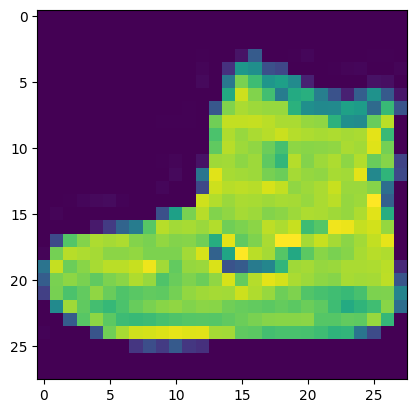

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])

Проведемо нормалізацію даних, розділяючи значення кожнрго пікселя на 255.

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Визначаємо функцію, що прийматиме гіперпараметри (функція активації, кількість нейронів в шарі, швидкість навчання) і повертатиме скомпільовану модель нейронної мережі.

In [6]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  hp_activation = hp.Choice('activation', values=['relu', 'swish', 'gelu'])
  hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=100)
  hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=100)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
  model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

Створимо об'єкт Keras Tuner, використовуючи алгоритм Hyperband для пошуку найкращих гіперпараметрів.

Тут ми вказуємо функцію побудови моделі, фактор зменшення, максимальну кількість епох

In [7]:
import keras_tuner as kt

tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=10,
                     factor=3,
                     directory='model',
                     project_name='fashion_mnist')

In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

Виконуємо пошук оптимальних гіперпараметрів.

тут ми вказуємо дані для еавчання, кількість епох, співвідношення валідаційного набору і також використовуємо методі ранньої ззупинки

In [10]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Отримуємо найкращі гіперпараметри, що були знайдені під час пошуку

In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Створюємо модкль із найліпшими гіперпараметрами і приступаємо до її навчання на тренувальних даних.

In [13]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[stop_early])

Epoch 1/30
1500/1500 [==============================] - 15s 9ms/step - loss: 0.4706 - accuracy: 0.8278 - val_loss: 0.3898 - val_accuracy: 0.8579
Epoch 2/30
1500/1500 [==============================] - 14s 9ms/step - loss: 0.3446 - accuracy: 0.8733 - val_loss: 0.3445 - val_accuracy: 0.8732
Epoch 3/30
1500/1500 [==============================] - 14s 9ms/step - loss: 0.3084 - accuracy: 0.8840 - val_loss: 0.3089 - val_accuracy: 0.8868
Epoch 4/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2811 - accuracy: 0.8935 - val_loss: 0.3331 - val_accuracy: 0.8792
Epoch 5/30
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2618 - accuracy: 0.9005 - val_loss: 0.3132 - val_accuracy: 0.8871
Epoch 6/30
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2450 - accuracy: 0.9063 - val_loss: 0.3072 - val_accuracy: 0.8934
Epoch 7/30
1500/1500 [==============================] - 14s 10ms/step - loss: 0.2312 - accuracy: 0.9117 - val_loss: 0.3352 - val_a

Перегляньмо метрики для показання ефективності нейронної мережі:


*   Графік точності на тренувальному та валідаційному наборах



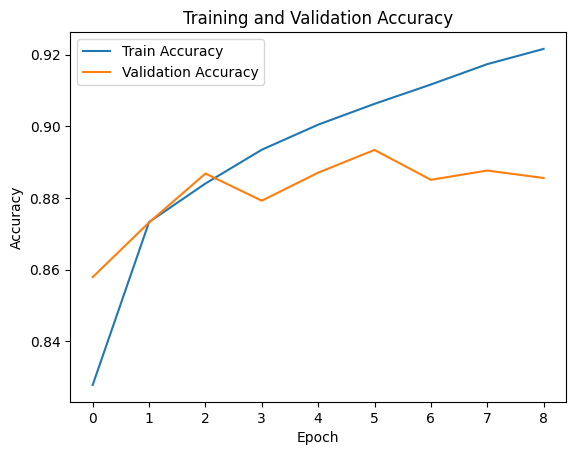

In [16]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

*   Графік втрат на тренувальному та валідаційному наборах




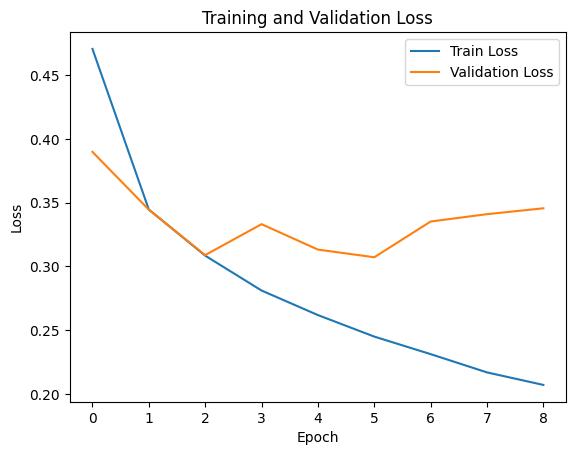

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

*   Графік точності та втрат на тестовому наборі



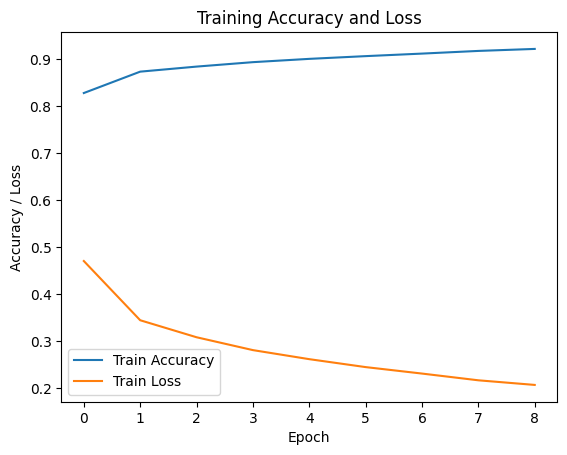

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()

Підведемо підсумок оцінки нашої натренованої моделі і виведемо значення втрат і точності моделі

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

313/313 [==============================] - 3s 8ms/step - loss: 0.3654 - accuracy: 0.8798
Test Loss: 0.3654, Test Accuracy: 0.8798


Підсумуймо :

*   Використання Keras Tuner дозволяє автоматично підбирати гіперпараметри моделі, що дозволяє покращити її точність без необхідності вручного перебору параметрів.
*   Вибір гіперпараметрів виконується за допомогою випадкового пошуку, і це дає нам можливість перебрати різні комбінації гіперпараметрів за коротки час
*   Early stopping дозволяє контролювати процес навчання та зупинити його, коли помилка на валідаційних даних погіршується. Цей метод доцільно використовувати коли ми маємо обмежені ресурси, а також час, оскільки метод зупиняє процес навчання, коли спостерігає, що помилка після певного часу починає зростати протягом наступних ітерацій
*   Ми провели оцінку нашої навченої моделі на тестовому наборі даних, підтвердивши її дієздатність та ефективність


В результаті точність нашої моделі складає майже 88%, що є хорошим показником для короткого періоду навчання
